### Importing packages

In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline                                               
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}      

from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
print(spectools_ir.__file__)

C:\Users\bbrad\miniconda3\lib\site-packages\spectools_ir\__init__.py


### Read in HITRAN data with extract_hitran_data

This example uses extract_hitran_data to find fundamental CO vibrational transitions in the M band.  A spectrum is read in from a FITS file.

In [3]:
hitran_data=extract_hitran_data('CO',4.58,5.5,vup=1)  #Outputs an astropy table
hitran_water=extract_hitran_data('H2O',4.58,5.5,eupmax=6000,aupmin=0.1)  #Outputs an astropy table

### Accounting for Doppler shifts

The cell below has a DataFrame with different Doppler shift measurements for each target and some observations.
Unless explicitly stated, each redshift has units of v/c.

* The "simbad_redshift" is the redshift listed by SIMBAD when possible. I couldn't find this for all targets.
* The "lineflux_avg_redshift" is calculated by averaging the "v_dop_fit" column of the lineflux table and dividing by *c*.
* The "lineflux_med_redshift" is calculated by taking the median of the "v_dop_fit" column of the lineflux table and dividing by *c*.
* The "n_lines_fit" column shows how many lines were successfully fit to give a sense of the sample size for the lineflux redshift calculations.

**Note: Since the lineflux fitting routine requires human judgement, it is possible to calculate different lineflux redshift values each time!**

To figure out which redshift to use, I plotted the raw vs redshift-corrected data for each value and each target. If SIMBAD did not have a redshift listed, I manually shifted the data to align it with the expected CO lines and noted the value I used in the "manual_redshift" column.

In [4]:
### Constructing a DataFrame of redshift values:

target_list = ['CITau', 'FZTau', 'IQTau', 'AS205', 'DoAr25', 'DoAr33', 'GKTau', 'HD143006', 'HPTau', 'IRAS04385', 'WSB52']

redshift_data = pd.DataFrame(data={'target':target_list,'simbad_redshift':np.array([0.000056,0.000053,0.000051,'----------',-0.000042,-0.000020,'----------',-0.000011,'----------',0.000054,-0.000018]), 'lineflux_avg_redshift':np.array([8.287403188972582e-05, 6.167566692537638e-05, 3.9213434436350086e-05, -1.9775651864217518e-05, 6.500960827601571e-05, 4.064045493023696e-09, 3.9435926632100225e-05, -2.4204216721348564e-05, 8.916085557921988e-05, 7.529437390769507e-06, 1.2263509542823756e-05]), 'lineflux_med_redshift':np.array([9.049851640708842e-05, 5.852846016579358e-05, 2.707268036347967e-05, -1.912968399707197e-05, 5.433825586263136e-05, 1.9642877564928053e-05, 4.511667097231745e-05, -2.367921488979874e-05, 8.81596860666029e-05, 7.529437390769507e-06, -4.562112627455105e-06]), 'n_lines_fit':[24,32,20,24,11,5,26,12,20,2,20], 'manual_redshift':['','','',-0.00002,'','',0.00004,'',0.00009,'',''],'observations':['SIMBAD shift works best','SIMBAD shift works best','SIMBAD shift works best','lineflux & manual redshift are in agreement','difficult to identify CO; SIMBAD & LF disagree','difficult to identify CO; SIMBAD & LF disagree','lineflux & manual redshift are in agreement','SIMBAD shift works best','lineflux & manual redshift are in agreement','extremely difficult to identify CO','LF avg, med strongly disagree; SIMBAD works']
,'best_shift':['simbad','simbad','simbad','manual','simbad','simbad','manual','simbad','manual','simbad','simbad']})

redshift_data

,target,simbad_redshift,lineflux_avg_redshift,lineflux_med_redshift,n_lines_fit,manual_redshift,observations,best_shift
0,CITau,5.6e-05,8.287403e-05,0.000090,24,,SIMBAD shift works best,simbad
1,FZTau,5.3e-05,6.167567e-05,0.000059,32,,SIMBAD shift works best,simbad
2,IQTau,5.1e-05,3.921343e-05,0.000027,20,,SIMBAD shift works best,simbad
3,AS205,----------,-1.977565e-05,-0.000019,24,-0.00002,lineflux & manual redshift are in agreement,manual
4,DoAr25,-4.2e-05,6.500961e-05,0.000054,11,,difficult to identify CO; SIMBAD & LF disagree,simbad
5,DoAr33,-2e-05,4.064045e-09,0.000020,5,,difficult to identify CO; SIMBAD & LF disagree,simbad
6,GKTau,----------,3.943593e-05,0.000045,26,0.00004,lineflux & manual redshift are in agreement,manual
7,HD143006,-1.1e-05,-2.420422e-05,-0.000024,12,,SIMBAD shift works best,simbad
8,HPTau,----------,8.916086e-05,0.000088,20,0.00009,lineflux & manual redshift are in agreement,manual
9,IRAS04385,5.4e-05,7.529437e-06,0.000008,2,,extremely difficult to identify CO,simbad


### Examining raw vs redshift-corrected data
This code is currently commented out (I have already tried the redshifts in the table above and found which ones work best)

if 2 == 0: ## this allows the code to be viewed and edited without running! I currently don't want / need this to run.

    ### Pull a target and its redshift from the table above:

    target = target_list[1] ### refer to the indices of the above table
    if np.array(redshift_data.loc[redshift_data['target']==target]['best_shift'])[0] == 'simbad':
        redshift = float(redshift_data.loc[redshift_data['target']==target]['simbad_redshift'])
    if np.array(redshift_data.loc[redshift_data['target']==target]['best_shift'])[0] == 'manual':
        redshift = float(redshift_data.loc[redshift_data['target']==target]['manual_redshift'])

    ### Read in FITS data containing spectrum.
    infile='C:/Users/bbrad/Desktop/reducs22.tar/'+target+'_orders.fits'
    hdulist=fits.open(infile) # header data unit
    data=hdulist[1].data
    wave=data['wave']
    flux=data['flux']

    ### Making the data into floats so that it plays nicely with Pandas:
    float_waves  = []
    float_fluxes = []
    for i in wave:
        float_waves.append(float(i))
    for i in flux:
        float_fluxes.append(float(i))

    ### Building a DataFrame
    all_data     = pd.DataFrame(data={'wave':np.array(float_waves),'flux':np.array(float_fluxes)}).dropna().sort_values(by='wave').reset_index(drop=True)

    ### Plotting
    plt.rcParams["figure.figsize"] = (20,8)
    plt.title('Accounting for Doppler Shift of '+target,fontsize=22)
    plt.plot(all_data['wave'],all_data['flux'],label='Original Data', c='red')
    plt.plot(all_data['wave']-5*redshift,all_data['flux'],label='Doppler Shift Subtracted', c='#1f77b4')
    plt.legend([Line2D([0], [0], color='red', lw=4),Line2D([0], [0], color='#1f77b4', lw=4), Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['Original Data', 'Doppler Shift Subtracted', 'CO Spectral Lines', 'H2O Spectral Lines'])
    plt.xlabel('Wavelength [$\mu$m]',fontsize=16)
    plt.ylabel('Flux [Jy]',fontsize=16)
    plt.vlines(x=hitran_water['wave'],ymin=min(all_data['flux']),ymax=max(all_data['flux']),color='m')
    plt.vlines(x=hitran_data['wave'],ymin=min(all_data['flux']),ymax=max(all_data['flux']),color='C1')
    plt.xlim(4.95,5.1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

### Plotting the Redshift-Corrected Spectra vs HITRAN CO, H2O lines:

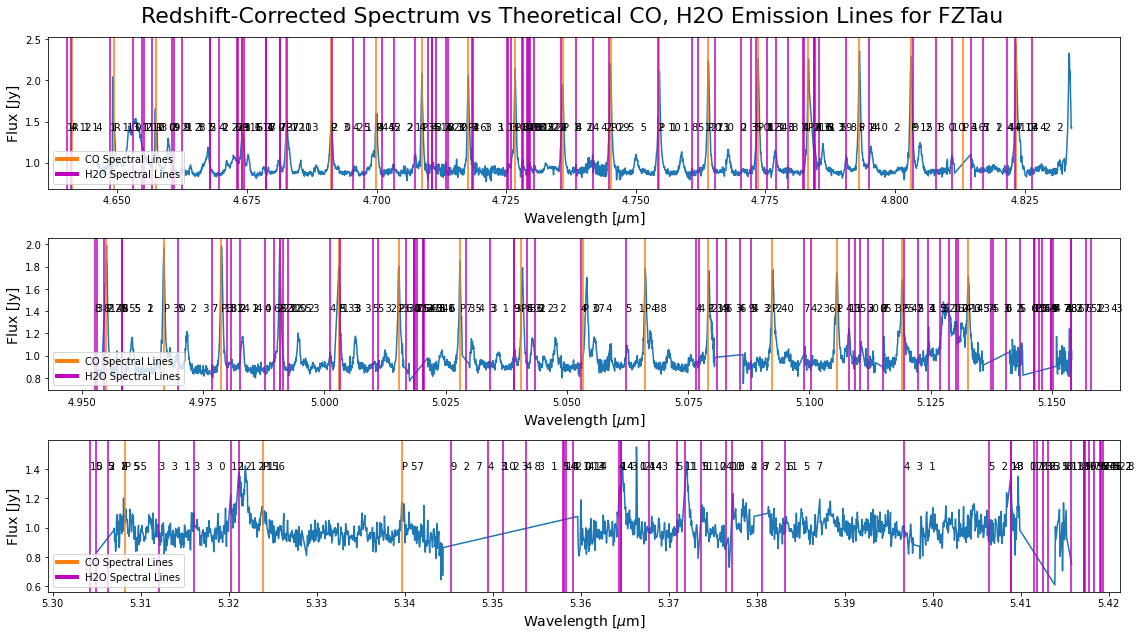



---------------------------------------------------------------------------------------------------------------




In [5]:
# Pull a target and its redshift from the table above:

target = target_list[1] # refer to table indices to figure out which number to enter here

if np.array(redshift_data.loc[redshift_data['target']==target]['best_shift'])[0] == 'simbad':
    redshift = float(redshift_data.loc[redshift_data['target']==target]['simbad_redshift'])
if np.array(redshift_data.loc[redshift_data['target']==target]['best_shift'])[0] == 'manual':
    redshift = float(redshift_data.loc[redshift_data['target']==target]['manual_redshift'])
    
#Read in FITS data containing spectrum.
infile='C:/Users/bbrad/Desktop/reducs22.tar/'+target+'_orders.fits'
hdulist=fits.open(infile) # header data unit
data=hdulist[1].data
wave=data['wave']-5*redshift ######  IMPORTANT! REDSHIFT IS BEING CORRECTED IN THIS LINE !!! The 5 is lambda naught
flux=data['flux']

# Making the data into floats so that it plays nicely with Pandas:
float_waves  = []
float_fluxes = []
for i in wave:
    float_waves.append(float(i))
for i in flux:
    float_fluxes.append(float(i))

# Building a DataFrame for plotting purposes:
all_data     = pd.DataFrame(data={'wave':np.array(float_waves),'flux':np.array(float_fluxes)}).dropna().sort_values(by='wave').reset_index(drop=True)
first_order  = all_data.loc[all_data['wave']<4.9]
second_order = all_data.loc[all_data['wave']>=4.9].loc[all_data['wave']<5.2]
third_order  = all_data.loc[all_data['wave']>=5.2]

first_order_wave  = np.array(first_order['wave'])
second_order_wave = np.array(second_order['wave'])
third_order_wave  = np.array(third_order['wave'])
first_order_flux  = np.array(first_order['flux'])
second_order_flux = np.array(second_order['flux'])
third_order_flux  = np.array(third_order['flux'])

# Plotting the spectrum:
fig=plt.figure(figsize=(16,9))
fig.suptitle('Redshift-Corrected Spectrum vs Theoretical CO, H2O Emission Lines for '+target,fontsize=22)

ax1=fig.add_subplot(311)
ax1.plot(first_order_wave,first_order_flux)
#ax1.set_xlim(4.64,4.78)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.83) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
for i,mywave in enumerate(hitran_water['wave']):
    if( (mywave>4.64) & (mywave<4.83) ):
        ax1.axvline(mywave,color='m')
        ax1.text(hitran_water['wave'][i],1.4,hitran_water['Qpp'][i].strip())
        ax1.legend([Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['CO Spectral Lines', 'H2O Spectral Lines'], loc='lower left')

ax1.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(312)
ax2.plot(second_order_wave,second_order_flux)
#ax2.set_xlim(4.8,4.92)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.16) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
for i,mywave in enumerate(hitran_water['wave']):
    if( (mywave>4.95) & (mywave<5.16) ):
        ax2.axvline(mywave,color='m')
        ax2.text(hitran_water['wave'][i],1.4,hitran_water['Qpp'][i].strip())
        ax2.legend([Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['CO Spectral Lines', 'H2O Spectral Lines'], loc='lower left')
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)    

if len(third_order_wave) != 0:
    ax3=fig.add_subplot(313)
    ax3.plot(third_order_wave,third_order_flux)
    #ax3.set_xlim(5.3,5.42)
    for i,mywave in enumerate(hitran_data['wave']):
        if( (mywave>5.3) & (mywave<5.42) ):
            ax3.axvline(mywave,color='C1')
            ax3.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
    for i,mywave in enumerate(hitran_water['wave']):
        if( (mywave>5.3) & (mywave<5.42) ):
            ax3.axvline(mywave,color='m')
            ax3.text(hitran_water['wave'][i],1.4,hitran_water['Qpp'][i].strip())
    ax3.legend([Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['CO Spectral Lines', 'H2O Spectral Lines'], loc='lower left')
    ax3.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
    ax3.set_ylabel('Flux [Jy]',fontsize=14)
    plt.xticks(ticks=arange(5.3,5.43,0.01))


plt.tight_layout()


plt.show()

print('\n\n---------------------------------------------------------------------------------------------------------------\n\n')

# Comparing Slabspec Models to the Data

### Generating Slabspec Models

Slabspec makes a model spectrum from a "slab" of gas - a column of gas with defined area, column density, and (single) temperature. The example below shows the creation of a CO spectrum from 4.58 to 5.2 microns.  Units are assumed to be SI (mks).  If convol_fwhm is specified, the model output will be convolved with a Gaussian with the given FWHM value (in km/s).  Both the convolved and unconvolved spectra are included in the output.

**Important note**: The model can produce wonky output if the model resolution ('res' parameter: resolution in microns) is not sufficient.  It's highly recommended that one check the output of a model against a model with higher resolution to make sure the output remains the same.

In [6]:
targets = np.array(['CITau', 'FZTau', 'IQTau', 'AS205', 'DoAr25', 'DoAr33', 'GKTau', 'HD143006', 'HPTau', 'IRAS04385', 'WSB52'])
distances = np.array([160,129,131,140,138,139,129,167,171,140,135])

### Make a slab model spectrum with make_spec

In [7]:
convol_fwhm = 30.
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
CO_model=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)
water_model=make_spec('H2O',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q1.txt


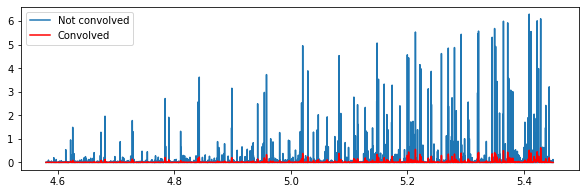

In [8]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(water_model['spectrum']['wave'],water_model['spectrum']['flux'],label='Not convolved')
ax1.plot(water_model['spectrum']['wave'],water_model['spectrum']['convolflux'],'r',label='Convolved')
ax1.legend()

### Plot slab model alongside redshift-corrected data

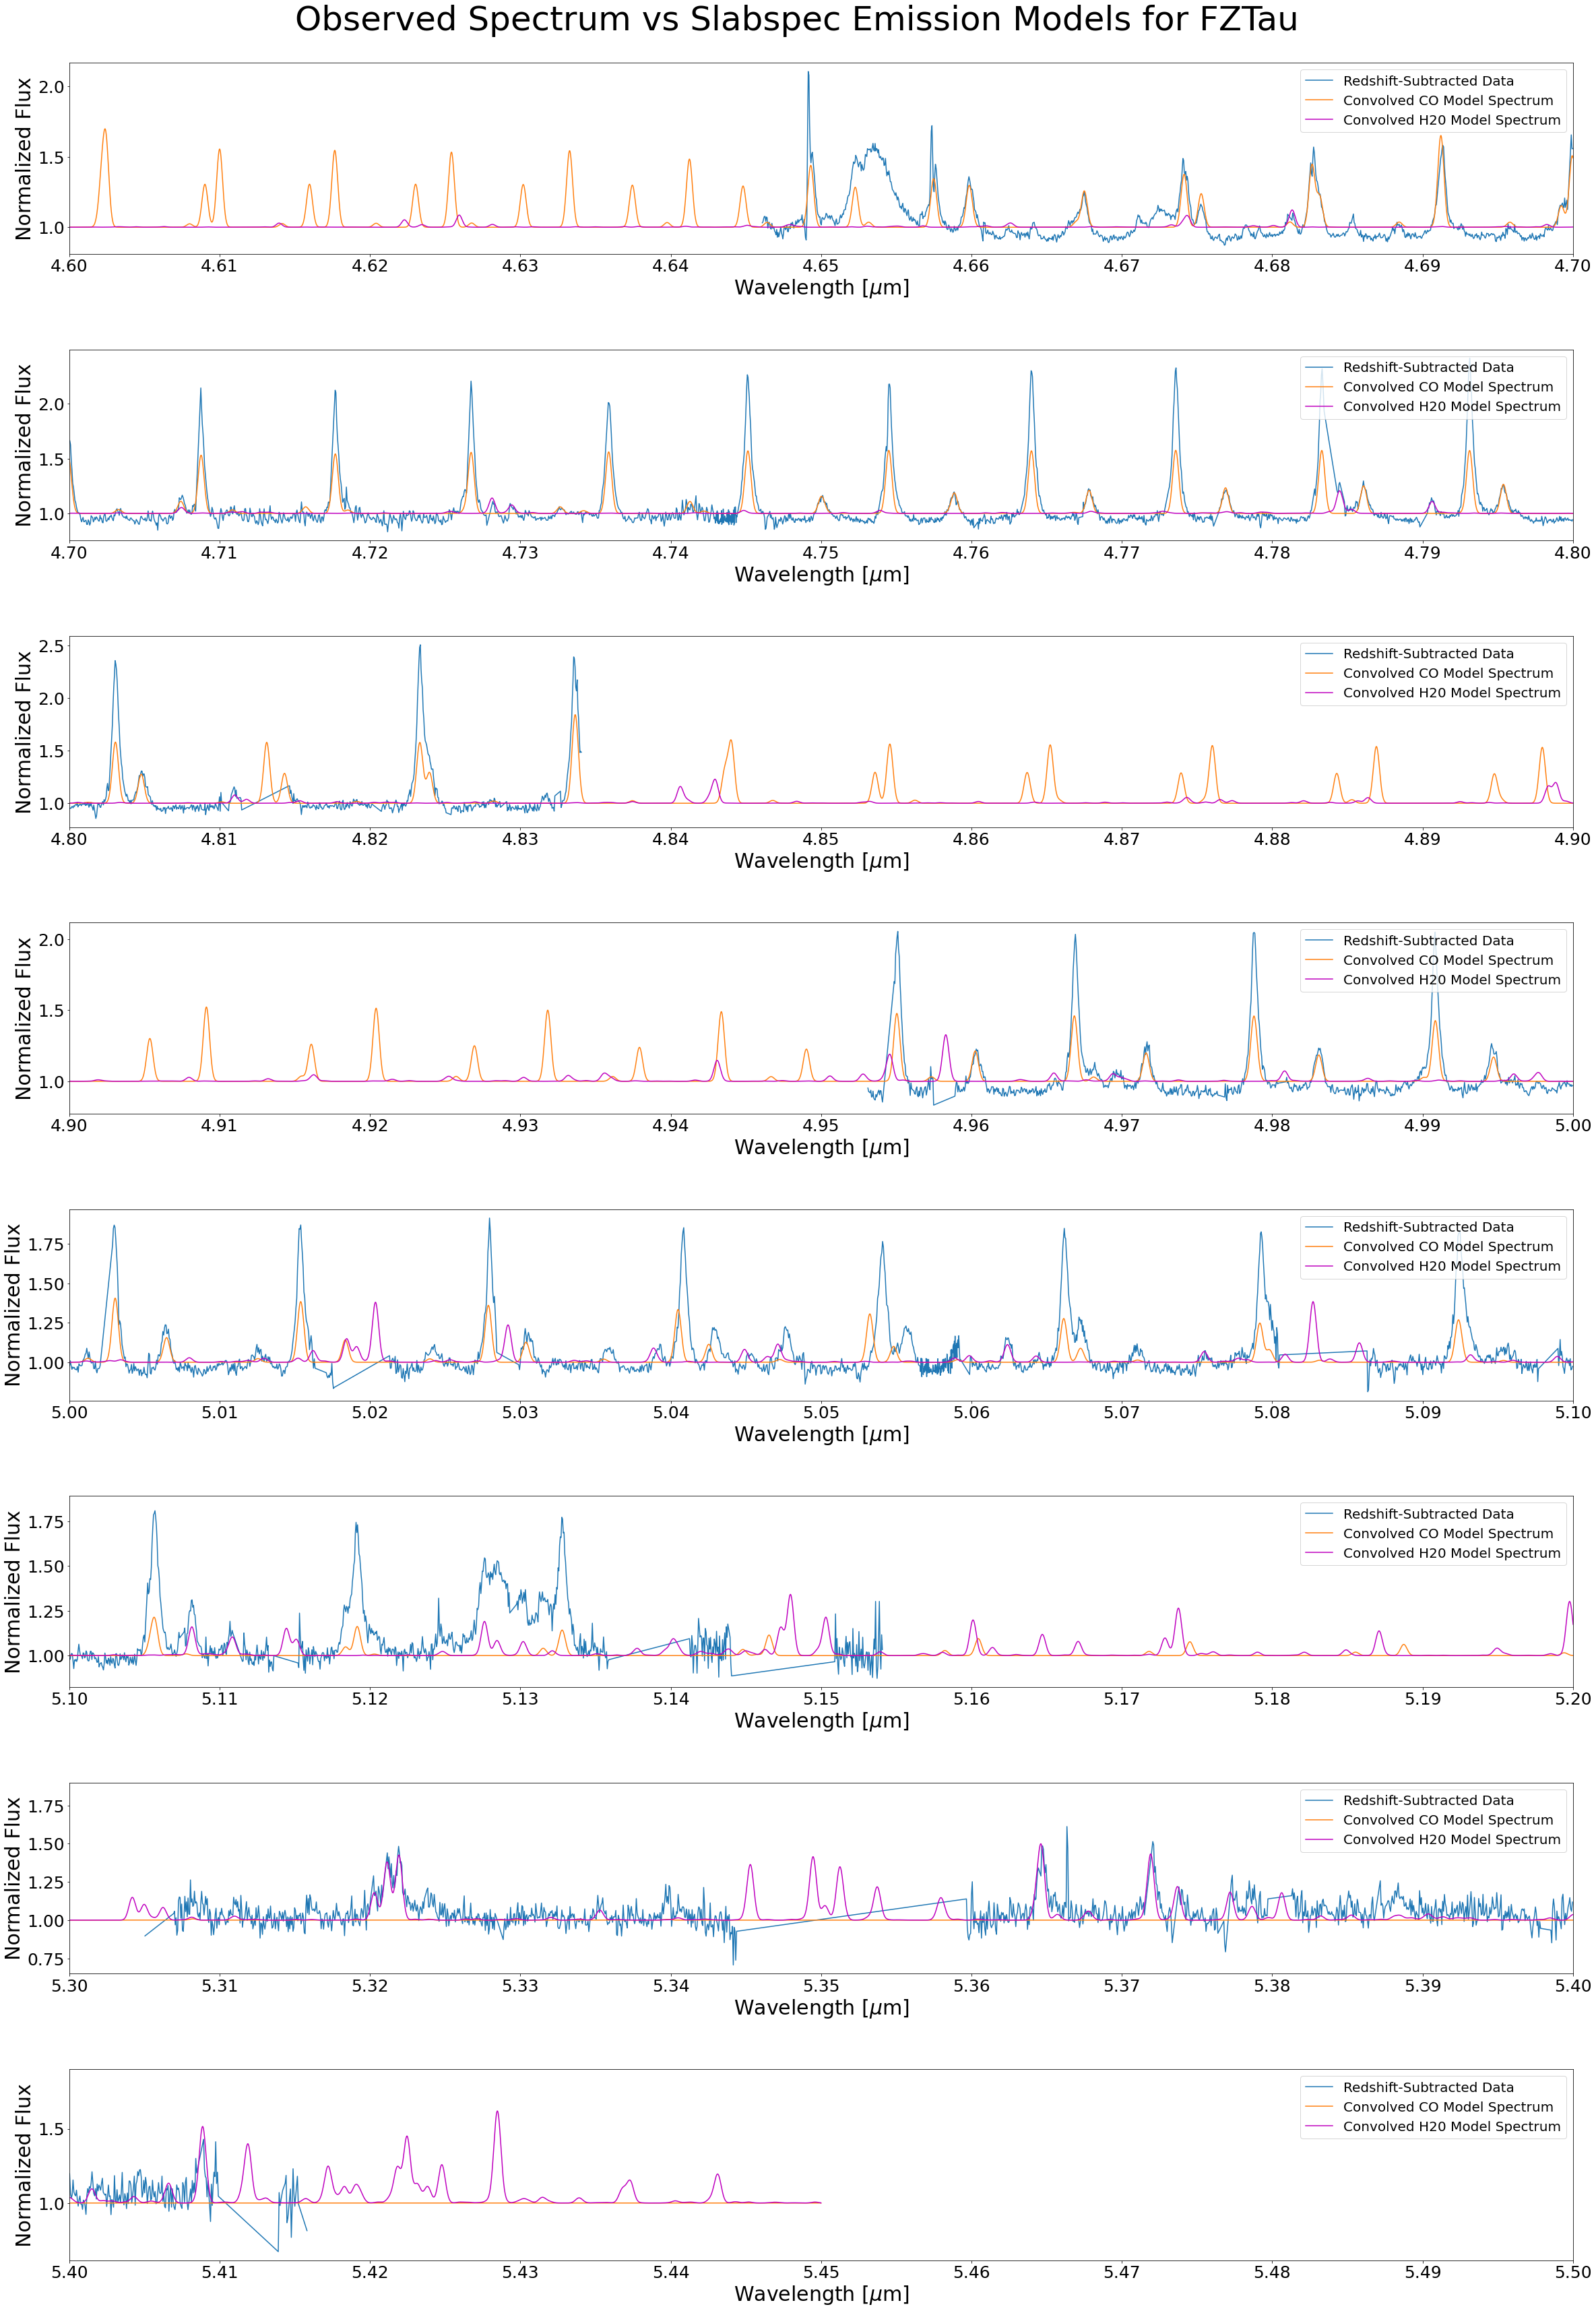

In [9]:
print('\n')
first_order_min = floor(min(all_data.loc[all_data['wave']<4.90]['wave'])*10)/10
first_order_max = ceil(max(all_data.loc[all_data['wave']<4.90]['wave'])*10)/10
second_order_min = floor(min(all_data.loc[all_data['wave']>4.90]['wave'])*10)/10
second_order_max = ceil(max(all_data.loc[all_data['wave']<5.20]['wave'])*10)/10


if len(all_data.loc[all_data['wave']>5.20]['wave']) != 0:
    third_order_min = floor(min(all_data.loc[all_data['wave']>5.20]['wave'])*10)/10
    third_order_max = ceil(max(all_data.loc[all_data['wave']>5.20]['wave'])*10)/10
    x_bounds = np.unique(np.concatenate([np.linspace(first_order_min, first_order_max-0.1, num=int(10*(first_order_max-first_order_min))),np.linspace(second_order_min, second_order_max-0.1, num=int(round(10*(second_order_max-second_order_min)))), np.linspace(third_order_min, third_order_max-0.1, num=int(round(10*(third_order_max-third_order_min))))]))
    
else:
    x_bounds = np.unique(np.concatenate([np.linspace(first_order_min, first_order_max-0.1, num=int(10*(first_order_max-first_order_min))),np.linspace(second_order_min, second_order_max-0.1, num=int(round(10*(second_order_max-second_order_min))))]))

n_subplots = len(x_bounds)

plt.figure(figsize=(40, 60))
plt.suptitle('Observed Spectrum vs Slabspec Emission Models for '+target,fontsize=50,y=0.9)

plt.subplots_adjust(hspace=0.5)
plt.xticks(fontsize=50)
for n in arange(0,n_subplots,1):
    ax = plt.subplot(n_subplots,1,n+1)
    ax.set_xticks(np.arange(x_bounds[n],x_bounds[n]+0.11,0.01))
    ax.set_xlim(x_bounds[n],x_bounds[n]+0.1)
    ax.set_xlabel('Wavelength [$\mu$m]',fontsize=30)
    ax.set_ylabel('Normalized Flux',fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.plot(all_data.loc[all_data['wave']>=x_bounds[n]].loc[all_data['wave']<=x_bounds[n]+0.1]['wave'],all_data.loc[all_data['wave']>=x_bounds[n]].loc[all_data['wave']<=x_bounds[n]+0.1]['flux']-(np.median(all_data['flux']))+1,label='Redshift-Subtracted Data')
    ax.plot(CO_model['spectrum']['wave'],CO_model['spectrum']['convolflux']+1,label='Convolved CO Model Spectrum',color='C1')
    ax.plot(water_model['spectrum']['wave'],water_model['spectrum']['convolflux']+1,label='Convolved H20 Model Spectrum',color='m')

    plt.legend(fontsize=20,loc='upper right')

In [10]:
print('Stopping notebook')

Stopping notebook


In [11]:
Stop!!!

SyntaxError: invalid syntax (3152237263.py, line 1)

## ----------------------------------------------------------------------------------------------------

# Other code (kind of a grab bag of tools not relevant to the above plot)

## Lineflux Calculator

Flux calculator will loop through a set of provided wavelengths, then perform a Gaussian and numerical computation of line flux at each location.  If one begins by using the helper tool "extract_hitran_data", the output will include transition-specific data in addition to the computed line fluxes.

### Calculate line fluxes for dataset, using locations specified in hitran dataset

calc_fluxes is now used to compute the line fluxes in the spectrum.  (Some additional code is added to read and write in the flux values for use in later parts of this notebook.)  Users can provide input values of the continuum level (cont), FWHM (fwhm_v) and Doppler shift of lines relative to vacuum rest wavelength (v_dop).  Users can also choose the size of the fit interval (sep_v), whether or not to vet the fits (vet_fits; highly recommended) and whether or not to plot (highly recommended).   The routine does little to no vetting on its own, so user vetting is highly recommended.

In [ ]:
#Calculate fluxes. Uncomment the following two lines to run the code
if 2 == 0: # prevents code from running
    lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)
    pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience
    lineflux_data=pickle.load(open('C:/Users/bbrad/Downloads/lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

In [ ]:
#lineflux_data

In [ ]:
### Using the wavelength and v_dop_fit from the lineflux_data to calculate an approximate Doppler shift:
if 2 == 0: # prevents code from running
    print('FOR TARGET '+target+':\n----------------')
    print('Number of lines:', len(lineflux_data['v_dop_fit']))
    print('Average Doppler shift from line flux:',np.mean(np.array(lineflux_data['v_dop_fit']))/299792.458)
    print('Median Doppler shift from line flux:',np.median(np.array(lineflux_data['v_dop_fit']))/299792.458)

Note that flux_calculator calculates fluxes using both a Gaussian fit and numerical integration.  The numerical integration sums from -3$\sigma$ to +3$\sigma$, where $\sigma$ is provided by the Gaussian fit. These values should be similar for Gaussian line shapes, but may be quite different for more complex line shapes, as for AA Tau. 

The figure below shows how the two compare for this example.

In [ ]:
if 2 == 0:
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, label='Numerical flux')
    ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
    ax1.legend()
    ax1.set_xlabel('Wavelength [microns]')
    ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

Note that, although calc_fluxes takes a full "hitran_data" table as input, the most minimal table it can function with is one that just contains a column named "wave", which holds wavelengths in microns.

In [ ]:
#Create minimal hitran database for testing.  It only includes wavelengths.
#test_hitran_data=hitran_data[['wave']].copy()
#test_lineflux_data=calc_fluxes(wave*1e3,flux,test_hitran_data,v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

You get out what you put in, though, so your output table will only have wavelengths and fit parameters (no HITRAN transition information).

### Create a composite lineshape using info from flux_calculator output

Flux calculator also has a routine that can make a composite lineshape from calc_fluxes output.

In [ ]:
#lineshape_data=make_lineshape(wave,flux,lineflux_data) # lineflux data could be from different order

In [ ]:
#fig=plt.figure()
#ax1=fig.add_subplot(111)
#ax1.plot(lineshape_data[0],lineshape_data[1])

#ax1.set_xlabel('Velocity [km/s]')
#ax1.set_ylabel('Arbitrary flux')

As with calc_fluxes, the routine can work with a minimal input table that includes a column named 'wave'.

In [ ]:
if 2 == 0: # prevents code from running
    lineflux_data_minimal=lineflux_data['wave'].copy()
    lineshape_data_minimal=make_lineshape(wave,flux,lineflux_data)

    fig=plt.figure()
    ax1=fig.add_subplot(111)
    ax1.plot(lineshape_data_minimal[0],lineshape_data_minimal[1])

    ax1.set_xlabel('Velocity [km/s]')
    ax1.set_ylabel('Arbitrary flux')

### Display resultant fluxes in a rotation diagram

Spectools_ir.utils has a function to make a rotation diagram, which can use calc_fluxes output as its dataset.  This example compares rotation diagrams for the Gaussian and numerical fluxes.

make_rotation_diagrams has a "units" keyword with values 'mks' (SI), 'cgs', or 'mixed'. Based on some precedent in the literature, 'mixed' units keeps most values in SI units, but wavenumbers in inverse cm.

In [ ]:
if 2 == 0: # prevents cell from running
    rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
    rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

    fig=plt.figure()
    ax1=fig.add_subplot(111)
    ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
    ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

    ax1.set_xlabel('Eup [K]')
    ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
    ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

Output from slabspec can also be displayed as a rotation diagram.

In [ ]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)
ax1.legend()

# Slab_fitter example use

slab_fitter uses the MCMC fitting code "emcee" to fit line fluxes with a slab model.  Priors are assumed to be flat, with boundaries provided by the user as input parameters.

In contrast to the slab model, slab_fitter uses solid angle in place of area.  Helper functions calc_solid_angle(radius, distance) and calc_radius(solid_angle,distance) can be used to convert between the two.  Calculations assume a face-on disk shape.

### Set up configuration

Configuration parameters are all stored in config.json, or another user-specified json file.  User must specify the range of temperatures, column densities, and solid angles, the number of walkers, the number of burnin samples, and the number of samples per walker.

slab_fitter naturally takes output of flux_calculator as input. (Other input examples are discussed below).

In [ ]:
myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

### Run retrieval

Running the retrieval can take a significant amount of time, so only run when ready. (Code below currently takes 9 minutes on my personal laptop.)

In [ ]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('C:/Users/bbrad/Downloads/test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

### Evaluate retrieval results

slab_fitter includes a few simple routines for evaluating and viewing the retrieval results.

**Note:** The examples here are not necessarily well-behaved samples.  Users should refer to emcee documentation and other sources for more info about MCMC sample vetting.

In [ ]:
#Trace plot - examine samples
trace_plot(postsamples)

In [ ]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [ ]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

In [ ]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()

While slab_fitter naturally works with flux_calculator output, the "read_data_from_file" routine is provided as a way to read a minimal column-delimited file, and output a slab_fitter-ready data frame.  A file must contain the columns:  'molec' (e.g., "H2O"), 'iso' (1 for most common, 2 for second most common, etc.),'lineflux' (W/m$^2$), 'error'  (W/m$^2$), and either 'wn'(cm$^{-1}$) or 'wave' (microns).  

**Important note**: read_data_from_file will use your input molecular parameters and wavelength or wavenumber to find other transition parameters in the HITRAN database.  Since it has limited information, it simply finds the transition with the closest wavelength.  Therefore, the wavelengths must be precise.  It's a good idea to check the output before proceeding further, to make sure the transitions are what you expect.

In [ ]:
!cat 'C:/Users/bbrad/Downloads/slab_fitter_input.txt'

data=read_data_from_file('C:/Users/bbrad/Downloads/slab_fitter_input.txt')

In [ ]:
data  #Are these the transitions you want?

In [ ]:
myconfig=Config()  #reads config.json by default, or can specify path to file
myconfig.display()

mydata=LineData(data)
#myretrieval=Retrieval(myconfig,mydata)  #Commented out because this line of code takes a long time to run.

# Example use of some utils functions

spectools_ir.utils contains a few other commonly-used utilities that one may find helpful for analyis of IR spectroscopy, including some routines specific to JWST-MIRI MRS.

### Extract HITRAN data for any molecule in the database

In [ ]:
hitran_data=extract_hitran_data('CH3OH',10,11,isotopologue_number=1,eupmax=5000,aupmin=0.1)  #Outputs an astropy table

In [ ]:
hitran_data

### Convolve a spectrum with a Gaussian spectral response function

Note: Convolving a spectrum is conceptually simple, but edge effects and NaNs in spectral data can cause headaches.  This routine deals nicely with both of those issues (though it's not fast)

In [ ]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
convolflux=spec_convol(wave,flux,30.)  #Inputs: wavelength, flux, FWHM of Gaussian SRF in km/s

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Convolve spectrum with a wavelength-dependent SRF

A utility function is provided that allows for a wavelength-dependent spectral response function (SRF).  Input spectral resolution must either be a single element (i.e., non wavelength-dependent) or have the same number of elements as the spectrum.  Note the resolution is given as $R = \frac{\lambda}{\Delta \lambda}$ rather than $v$ in this function.

In [ ]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
myR=np.linspace(10000,25000.,num=np.size(wave))
convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                                         #myR must either have 1 value, or be an array of same size as wave and flux

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

#Note the wavelength-dependent line width

### Some utility functions specific to JWST MIRI-MRS

A simple routine is provided to approximate Figure 14 from Wells et al. 2015, which provides R as a function of wavelength.  This function utilizes linear approximations and should only be used as a rough reference.

In [ ]:
make_miri_mrs_figure(figsize=(7,3))

get_miri_mrs_wavelengths provides the wavelength limits of an MRS sub-band

In [ ]:
get_miri_mrs_wavelengths('1A')

The covolution routine can be combined with slabspec output to create a model with a wavelength-dependent SRF

In [ ]:
#Get resolution for a range of wavelengths and use as input to wavelength-dependent convolution
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.87,wmax=5.,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']

#Use get_miri_mrs_resolution to get wavelength resolution array
myR=get_miri_mrs_resolution('1A',wave)

convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Other small helper functions

In [ ]:
print(sigma_to_fwhm(20.))

print(fwhm_to_sigma(47.096))

print(get_molmass('H2O',isotopologue_number=2))

print(compute_thermal_velocity('H2',500.))
print(compute_thermal_velocity('H2',1000.))

print(wn_to_k(2000./u.cm))

# -----------------------------

# ARCHIVED CODE

# -----------------------------


#### This cell is no longer being used. It calculates a rough estimate of the average Doppler shift by comparing each expected CO wavelength to the nearest flux maximum within a certain wavelength range. It is more accurate if you have a general idea of the Doppler shift already so you can input a good wavelength search range. It is an interesting exercise but not particularly useful because SIMBAD has more accurate Doppler shifts recorded.

for target in target_list: 
    
    #Read in FITS data containing spectrum.
    infile='C:/Users/bbrad/Desktop/reducs22.tar/'+target+'_orders.fits'
    hdulist=fits.open(infile) # header data unit
    data=hdulist[1].data
    wave=data['wave']
    flux=data['flux']
    
    #Put the spectrum in a DataFrame
    float_waves  = []
    float_fluxes = []
    for i in wave:
        float_waves.append(float(i))
    for i in flux:
        float_fluxes.append(float(i))
    all_data = pd.DataFrame(data={'wave':np.array(float_waves),'flux':np.array(float_fluxes)}).dropna().sort_values(by='wave').reset_index(drop=True)

    for line_search_range in [0.0001]: # 
        difference_array = []
        for i in np.array(hitran_data['wave']):
            #print('\nTheoretical Wavelength in micrometers:', i)
            search_range = all_data.loc[all_data['wave']<=i+line_search_range].loc[all_data['wave']>=i-line_search_range]
            if len(search_range) != 0:
                search_result = float(np.array(search_range.loc[search_range['flux']==np.max(search_range['flux'])]['wave'])[0])
                #print('Closest peak: ', search_result)
                #print('\n-----------\n')
                difference_array.append(search_result-i)